## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
import time
import codecs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [2]:
# downloading treebank dataset using nltk
nltk.download('treebank')


[nltk_data] Downloading package treebank to /Users/chintu/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [3]:
# downloading universal tagset using nltk
nltk.download('universal_tagset')


[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/chintu/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [4]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
#First five sentences in the dataset
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [6]:
# Setting the random seed to save the state of function
random.seed(1234)

# Divide the data into training and test sets
train_data_set, test_data_set = train_test_split(nltk_data,train_size=0.95)

# Get the length of training and test sets
print(len(train_data_set))
print(len(test_data_set))

3718
196


In [7]:
# Getting list of tagged words in training set
train_tagged_words = [tup for sent in train_data_set for tup in sent]

# Get the length of the total tagged words in training set
len(train_tagged_words)

95494

In [8]:
# Get the first 10 tokens in the training data set
tokens = [pair[0] for pair in train_tagged_words]

# list 10 tokens
tokens[:10]

['The',
 'Ministry',
 'of',
 'International',
 'Trade',
 'and',
 'Industry',
 'summoned',
 'executives',
 'from']

In [9]:
# total unique words in training data set
unique_words = set(tokens)
print(len(unique_words))

12088


In [10]:
# find the number of pos tags in the training corpus. As mentioned in the assignment, it should be 12.
tags = set([pair[1] for pair in train_tagged_words])
print(len(tags))
print(tags)

12
{'ADV', 'CONJ', 'PRON', 'ADJ', 'NUM', 'DET', '.', 'X', 'PRT', 'NOUN', 'ADP', 'VERB'}


### Build the vanilla Viterbi based POS tagger

In [11]:
# Create numpy array of no of pos tags by total vocabulary
total_tags = len(tags)
vocabulary = len(unique_words)

# Getting word given tag
w_given_t = np.zeros((total_tags, vocabulary))

In [12]:
# Emission Probability: computing the probability of a word given a tag
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# Transition Probability: compute tag state t2 given tag state t1

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# Now need to create a matrix of POS tags
# creating t x t (pos tags x pos tags)transition matrix of tags
# each column represents t2, each row is t1
# thus Matrix(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
# convert the matrix to a dataframe for better readability/understanding
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,ADV,CONJ,PRON,ADJ,NUM,DET,.,X,PRT,NOUN,ADP,VERB
ADV,0.080200,0.006323,0.014642,0.132113,0.030948,0.069884,0.134443,0.023627,0.014642,0.032612,0.119135,0.341431
CONJ,0.055738,0.000468,0.058548,0.117096,0.042155,0.119438,0.035597,0.007494,0.005152,0.350820,0.048244,0.159251
PRON,0.032634,0.005439,0.008159,0.076146,0.007382,0.009324,0.042347,0.089744,0.012044,0.209402,0.022533,0.484848
ADJ,0.004763,0.017080,0.000657,0.067335,0.021186,0.004763,0.064378,0.020529,0.010839,0.698144,0.078010,0.012317
NUM,0.002634,0.013169,0.001171,0.033363,0.185543,0.003219,0.118232,0.209833,0.026924,0.351478,0.035704,0.018730
DET,0.012926,0.000483,0.003262,0.204035,0.022832,0.005557,0.017637,0.045180,0.000242,0.637352,0.009906,0.040590
.,0.052580,0.057694,0.064154,0.044145,0.081920,0.174069,0.092867,0.027097,0.002243,0.222611,0.091969,0.088650
X,0.025814,0.010261,0.055315,0.016354,0.002886,0.054674,0.164983,0.074234,0.185506,0.062530,0.144460,0.202982
PRT,0.010194,0.002302,0.018415,0.084183,0.056889,0.102598,0.042091,0.013154,0.001644,0.245972,0.019730,0.402828
NOUN,0.016945,0.042437,0.004857,0.012417,0.009568,0.012892,0.240925,0.028705,0.043678,0.263969,0.176758,0.146812


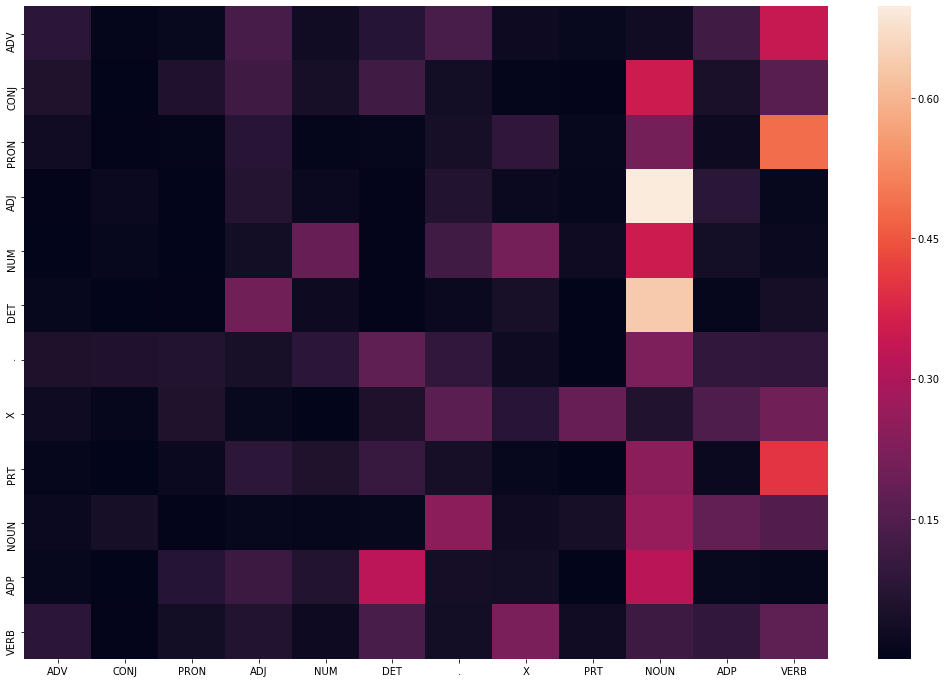

In [16]:
# constructing heatmap of tags matrix created in above step
# It indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

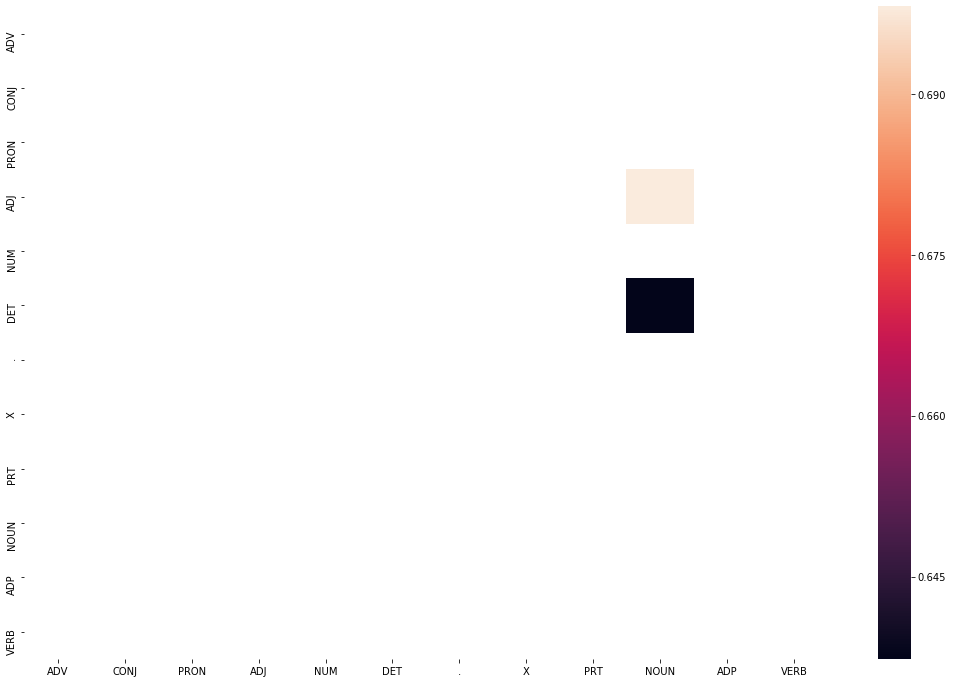

In [17]:
# frequent tags used and filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

From the above graph, it is clear that noun-determinant and noun-adjective are highly corelated. We have taken the corelation index > 0.5.

In [18]:
# Logic to create Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [19]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset as 
# running on full data set will take more time
# list of tagged words in test set
test_run_base = [tup for sent in test_data_set for tup in sent]

# list of  words which are untagged in test set
test_tagged_words = [tup[0] for sent in test_data_set for tup in sent]

In [20]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()

In [21]:
# Total time taken to train the algorithm
difference = end-start
print(difference)

1003.7986407279968


In [22]:
# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_accuracy = len(check)/len(tagged_seq)
print(viterbi_accuracy)

0.9108452335005789


In [23]:
# Read the text file provided in assignment. This text file is present in the root directory of python notebook i.e in the same folder
lines=[]
text_content = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in text_content:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

### Solve the problem of unknown words

In [24]:
# print the content in lines array list
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [25]:
# Strip the special characters and empty strings in the list file
test_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [26]:
# Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('Precious', 'ADV'), ('Precious', 'ADJ'))],
 [('being', 'VERB'), (('influenced', 'ADV'), ('influenced', 'VERB'))],
 [('*-1', 'X'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('William', 'NOUN'), (("O'Neill", 'ADV'), ("O'Neill", 'NOUN'))],
 [('at', 'ADP'), (('Elders', 'ADV'), ('Elders', 'NOUN'))],
 [('products', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('The', 'DET'), (('Fairlawn', 'ADV'), ('Fairlawn', 'NOUN'))],
 [('said', 'VERB'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('full-year', 'ADV'), ('full-year', 'ADJ'))],
 [('full-year', 'ADJ'), (('profit', 'VERB'), ('profit', 'NOUN'))],
 [('$', '.'), (('148', 'ADV'), ('148', 'NUM'))],
 [('a', 'DET'), (('pre-approved', 'ADV'), ('pre-approved', 'ADJ'))],
 [('loan', 'NOUN'), (('up', 'PRT'), ('up', 'ADP'))],
 [('throws', 'VERB'), (('in', 'ADP'), ('in', 'PRT'))],
 [('*', 'X'), (('saving', 'ADV'), ('saving', 'VERB'))],
 [('pick', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('the', 'DET'), (('slack', 'ADJ'), ('sl

Most of the words which are not present in training set are simply assigned the first pos tag in the training pos tagset.

Let us do the analysis on the test file provided in assignment. We have already read it before.

In [27]:
# downloading punkt otherwise it will throw error
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/chintu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
#Get the predictions on the test sentences
sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[('Android', 'ADV'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADV'),
 ('.', '.'),
 ('Android', 'ADV'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADV'),
 ('worldwide', 'ADV'),
 ('on', 'ADP'),
 ('smartphones', 'ADV'),
 ('since', 'ADP'),
 ('2011', 'ADV'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADV'),
 ('.', '.'),
 ('Google', 'ADV'),
 ('and', 'CONJ'),
 ('Twitter', 'ADV'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADV'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADV'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADV'),
 ("'s", 'PRT'),
 ('firehose', 'ADV'),
 ('.', '.'),
 ('Twitter', 'ADV'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADV'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU

For words like 'Android','Google' the first tag in the training pos tagset is given. Let us see if these words exist in the training corpus or not.

In [29]:
#Get the tokens in the test file
sample_words=[tokens for line in test_lines for tokens in word_tokenize(line)]

In [30]:
#Get the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['personality',
 'OS',
 'messages',
 'tournament',
 'NASA',
 'domineering',
 '2015',
 '21st',
 '2013',
 'worldwide',
 'Google',
 'online',
 'invited',
 'Cup',
 'Android',
 'FIFA',
 '2018',
 '2011',
 'trips',
 'firehose',
 'Twitter',
 'arriving',
 'tweets',
 'contested',
 'smartphones',
 'ICESAT-2',
 'Satellite',
 'interact']

As all these above words are not present in the training set, they are tagged as default tags.

In [31]:
# To verify what tags are assigned for unknown words not present in training dataset
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'ADV'),
 ('Google', 'ADV'),
 ('Android', 'ADV'),
 ('OS', 'ADV'),
 ('worldwide', 'ADV'),
 ('smartphones', 'ADV'),
 ('2011', 'ADV'),
 ('2013', 'ADV'),
 ('Google', 'ADV'),
 ('Twitter', 'ADV'),
 ('2015', 'ADV'),
 ('Google', 'ADV'),
 ('Twitter', 'ADV'),
 ('firehose', 'ADV'),
 ('Twitter', 'ADV'),
 ('online', 'ADV'),
 ('interact', 'ADV'),
 ('messages', 'ADV'),
 ('tweets', 'ADV'),
 ('domineering', 'ADV'),
 ('personality', 'ADV'),
 ('2018', 'ADV'),
 ('FIFA', 'ADV'),
 ('Cup', 'ADV'),
 ('21st', 'ADV'),
 ('FIFA', 'ADV'),
 ('Cup', 'ADV'),
 ('tournament', 'ADV'),
 ('contested', 'ADV'),
 ('Cup', 'ADV'),
 ('trips', 'ADV'),
 ('arriving', 'ADV'),
 ('NASA', 'ADV'),
 ('invited', 'ADV'),
 ('ICESAT-2', 'ADV'),
 ('Satellite', 'ADV')]

So it clearly assigns the first default tag

In [32]:
# Now we will import Counter to see the number of tags assigned in each category(total 12 category we have)
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'DET': 8278,
         'NOUN': 27382,
         'ADP': 9349,
         'CONJ': 2135,
         'VERB': 12842,
         'X': 6237,
         'PRT': 3041,
         '.': 11145,
         'ADJ': 6089,
         'PRON': 2574,
         'ADV': 3005,
         'NUM': 3417})

In [33]:
# Count of incorrectly classified words
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'ADV': 337,
         'ADP': 26,
         'VERB': 32,
         'PRT': 7,
         'ADJ': 20,
         'NOUN': 31,
         'DET': 8,
         'NUM': 1})

In [34]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20767793178632613


[('summoned', 'VERB'),
 ('expressed', 'VERB'),
 ('frightened', 'VERB'),
 ('spotted', 'VERB'),
 ('lacked', 'VERB'),
 ('preferred', 'VERB'),
 ('hired', 'VERB'),
 ('ordered', 'VERB'),
 ('received', 'VERB'),
 ('moved', 'VERB'),
 ('carried', 'VERB'),
 ('allowed', 'VERB'),
 ('used', 'VERB'),
 ('entrenched', 'VERB'),
 ('trimmed', 'VERB'),
 ('totaled', 'VERB'),
 ('opened', 'VERB'),
 ('ended', 'VERB'),
 ('disappointed', 'VERB'),
 ('showed', 'VERB')]

Around 20% of words which end with 'ed' are verbs. Though it is 20% it is high because this is universal tagset and Verbs contain all the forms of verbs

In [35]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:20]

0.10855007008254167


[('according', 'VERB'),
 ('managing', 'VERB'),
 ('giving', 'VERB'),
 ('looking', 'VERB'),
 ('including', 'VERB'),
 ('According', 'VERB'),
 ('holding', 'VERB'),
 ('fighting', 'VERB'),
 ('following', 'VERB'),
 ('pumping', 'VERB'),
 ('trading', 'VERB'),
 ('reciting', 'VERB'),
 ('offering', 'VERB'),
 ('contesting', 'VERB'),
 ('leaving', 'VERB'),
 ('Adopting', 'VERB'),
 ('getting', 'VERB'),
 ('complaining', 'VERB'),
 ('affecting', 'VERB'),
 ('helping', 'VERB')]

In [36]:
# Lets see percentage of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6089
4251
0.6981441944490064


Total of around 70 percent adjectives are followed by nouns

In [37]:
# Lets see percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

8278
5276
0.6373520173955062


Around 63 percent determinants are followed by nouns.

In [38]:
# Lets see percentage of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

3005
1026
0.34143094841930116


Around 34 percent adverbs are followed by verbs. So let's create a pattern and modify viterbi algorithm.

In [39]:
# specify patterns for tagging
pattern = [
    (r'.*ing$', 'VERB'),                # ending with ing
    (r'.*ed$', 'VERB'),                 # past tense verbs
    (r'.*es$', 'VERB'),                 # singular present verbs
    (r'.*ould$', 'VERB'),               # modal verbs
    (r'.*\'s$', 'NOUN'),                # possessive nouns
    (r'.*s$', 'NOUN'),                  # plural nouns
    (r'[-+]?\d*\.\d+|\d+', 'NUM'),      # Number with floating values
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'[A-Z ]+', 'NOUN'),               # all caps eg. FIFA, NASA, etc
    (r'.*Twitter$', 'NOUN'),            # keywords like Twitter, Android, Google as noun
    (r'.*Android$', 'NOUN'),
    (r'.*Google$', 'NOUN'),
    (r'.*', 'NOUN')                     # default value as noun
]

In [40]:
# Rule based tagging
def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [41]:
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_data_set)) for x in range(5)]

# list of sents
test_run = [test_data_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
#test_run

# tagging the test sentences
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)

print(tagged_seq)

nullified
VERB
opposite
NOUN
[('``', '.'), ('Profit', 'NOUN'), ('may', 'VERB'), ('be', 'VERB'), ('low', 'ADJ'), (',', '.'), ('but', 'CONJ'), ('at', 'ADP'), ('least', 'ADJ'), ('costs', 'NOUN'), ('should', 'VERB'), ('be', 'VERB'), ('covered', 'VERB'), ('*-1', 'X'), ('.', '.'), ('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('real', 'ADJ'), ('issue', 'NOUN'), ('raised', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('the', 'DET'), ('Wedtech', 'NOUN'), ('scandal', 'NOUN'), ('.', '.'), ('As', 'ADP'), ('individual', 'ADJ'), ('investors', 'NOUN'), ('have', 'VERB'), ('turned', 'VERB'), ('away', 'ADV'), ('from', 'ADP'), ('the', 'DET'), ('stock', 'NOUN'), ('market', 'NOUN'), ('over', 'ADP'), ('the', 'DET'), ('years', 'NOUN'), (',', '.'), ('securities', 'NOUN'), ('firms', 'NOUN'), ('have', 'VERB'), ('scrambled', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('find', 'VERB'), ('new', 'ADJ'), ('products', 'NOUN'), ('that', 'ADP'), ('brokers', 'NOUN'), ('find', 'VERB'), ('*T*-40', 'X'), ('easy', 'ADJ'), ('0', 'X'),

In [42]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9809523809523809


In [43]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('products', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('an', 'DET'), (('opposite', 'NOUN'), ('opposite', 'ADJ'))]]

In [44]:
# applying on the Test sentence provided

sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

rulebased_test_tagged_seq = modified_Viterbi_rule_based(words)

print(tagged_seq)

rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('``', '.'), ('Profit', 'NOUN'), ('may', 'VERB'), ('be', 'VERB'), ('low', 'ADJ'), (',', '.'), ('but', 'CONJ'), ('at', 'ADP'), ('least', 'ADJ'), ('costs', 'NOUN'), ('should', 'VERB'), ('be', 'VERB'), ('covered', 'VERB'), ('*-1', 'X'), ('.', '.'), ('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('real', 'ADJ'), ('issue', 'NOUN'), ('raised', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('the', 'DET'), ('Wedtech', 'NOUN'), ('scandal', 'NOUN'), ('.', '.'), ('As', 'ADP'), ('individual', 'ADJ'), ('investors', 'NOUN'), ('have', 'VERB'), ('turned', 'VERB'), ('away', 'A

#### Evaluating tagging accuracy

In [45]:
# Modified version - 2
def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [46]:
# Viterbi heuristic lexicon based algorithm
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_data_set)) for x in range(5)]

# list of sents
test_run = [test_data_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
print(tagged_seq)

nullified
VERB
opposite
NOUN
[('``', '.'), ('Profit', 'NOUN'), ('may', 'VERB'), ('be', 'VERB'), ('low', 'ADJ'), (',', '.'), ('but', 'CONJ'), ('at', 'ADP'), ('least', 'ADJ'), ('costs', 'NOUN'), ('should', 'VERB'), ('be', 'VERB'), ('covered', 'VERB'), ('*-1', 'X'), ('.', '.'), ('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('real', 'ADJ'), ('issue', 'NOUN'), ('raised', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('the', 'DET'), ('Wedtech', 'NOUN'), ('scandal', 'NOUN'), ('.', '.'), ('As', 'ADP'), ('individual', 'ADJ'), ('investors', 'NOUN'), ('have', 'VERB'), ('turned', 'VERB'), ('away', 'ADV'), ('from', 'ADP'), ('the', 'DET'), ('stock', 'NOUN'), ('market', 'NOUN'), ('over', 'ADP'), ('the', 'DET'), ('years', 'NOUN'), (',', '.'), ('securities', 'NOUN'), ('firms', 'NOUN'), ('have', 'VERB'), ('scrambled', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('find', 'VERB'), ('new', 'ADJ'), ('products', 'NOUN'), ('that', 'ADP'), ('brokers', 'NOUN'), ('find', 'VERB'), ('*T*-40', 'X'), ('easy', 'ADJ'), ('0', 'X'),

In [47]:
# accuracy of lexicon based
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9809523809523809


[[('products', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('an', 'DET'), (('opposite', 'NOUN'), ('opposite', 'ADJ'))]]

In [48]:
# Applying on test sentence to verify the result
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

lexicon_test_tagged_seq = modified_Viterbi_lexicon_based(words)

print(lexicon_test_tagged_seq)

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [49]:
print("Vannila Viterbi Accuracy: "+ str(viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.9108452335005789
Rule Based Viterbi Accuracy: 0.9809523809523809
Lexicon Based Viterbi Accuracy: 0.9809523809523809


From the above data, it is clear that rule based and lexicon based algorithm giv more accuracy compared to normal vanila based accuracy.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Following are conclusions dereived after applying rule based/ lexicon based algorithm:

. Words like Google, Android, Twitter were incorrectly tagged by original POS tagger. After applying modified Viterbi algorithm, those words are tagged as NOUN.

. Words like 'NASA', 'FIFA' are tagged as NOUN by modified Viterbi algorithm.

. Words ending with 'ing' , 'ed' are tagged as VERB in Rule based tagging.

. Applied the pattern for number. So words with integer or float type are assigned as NUM type.

. Modified Viterbi Accuracy also improved as compared to default Viterbi algorithm.